In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_ , or_, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

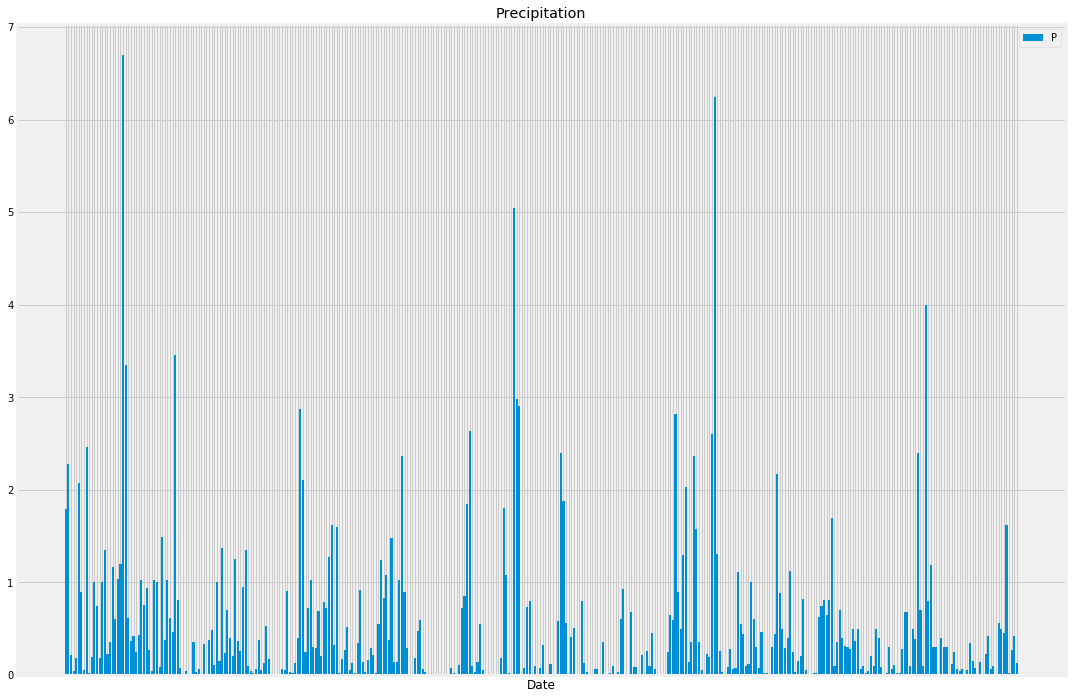

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
# Calculate the date 1 year ago from the last data point in the database

#Returns the last row in the datebase
obj = session.query(Measurement).order_by(Measurement.date.desc()).first()

#Convert date range to datetime
dates = [obj.date]   
l = [d.date() for d in pd.to_datetime(dates)] 

past_year= l[0] - timedelta(days = 365)

precipt = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_year).all()

df_precipt =pd.DataFrame(precipt, columns=['date', 'precipitation'])
df_precipt.set_index(df_precipt['date'], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax.bar(df_precipt["date"], df_precipt["precipitation"])
ax.set_title('Precipitation')
ax.set_xlabel('Date')
ax.legend('Precipitation')
fig.tight_layout()
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precipt.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(
    Measurement.station, func.count(Measurement.tobs))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station_stats = session.query(
    func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= past_year).all()
active_station_stats
#group_by(Measurement.station)\
#order_by(func.max(Measurement.tobs).desc()).all()

[(59.0, 83.0, 73.10795454545455)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.station, Measurement.tobs).filter(and_(Measurement.station == 'USC00519281',
                                                                                          Measurement.date >= past_year)).all()

#print(temp)

df_temp =pd.DataFrame(temp, columns=['station', 'tobs'])
df_temp.set_index(df_temp['station'], inplace=True)
df_temp



,station,tobs
station,,
USC00519281,USC00519281,77.0
USC00519281,USC00519281,77.0
USC00519281,USC00519281,80.0
USC00519281,USC00519281,80.0
USC00519281,USC00519281,75.0
...,...,...
USC00519281,USC00519281,77.0
USC00519281,USC00519281,77.0
USC00519281,USC00519281,76.0


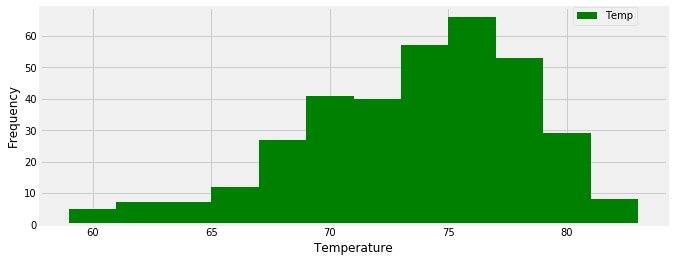

In [16]:
fig1, ax1=plt.subplots()
fig1.set_figwidth(10)
ax1.hist(df_temp['tobs'], bins=12, color='green', label="Temp")
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Frequency')
ax1.legend(bbox_to_anchor=(.85, 1), loc=2, borderaxespad=0.)
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2016-08-08', '2016-08-22')
my_trip


[(71.0, 78.3061224489796, 83.0)]

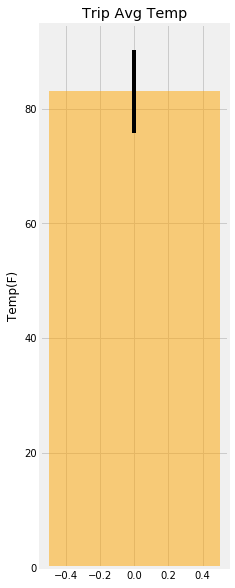

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = my_trip[0][0]
tmax = my_trip[0][1]
tavg = my_trip[0][2]
y_err = tmax-tmin

fig3, ax3 = plt.subplots()
fig3.set_figheight(10)
fig3.set_figwidth(3)
ax3.bar(0, tavg, yerr=y_err, align="center", width=1, color="orange", alpha=0.5)
ax3.set_title('Trip Avg Temp')
ax3.set_ylabel("Temp(F)")
fig.tight_layout()
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
j = session.query(*sel).join(Station, Station.station == Measurement.station)\
                                .group_by(Measurement.station)\
                                .filter(Measurement.date >= '2016-08-08').filter(Measurement.date <= '2016-08-22')\
                                .order_by(desc(func.sum(Measurement.prcp)))\
                                .all()
print (j)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 9.299999999999999), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.01), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.29), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.8300000000000001), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.5800000000000001), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.23), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
daily_normals('08-08')
daily_normals('08-09')
daily_normals('08-10')
daily_normals('08-11')
daily_normals('08-12')
daily_normals('08-13')
daily_normals('08-14')
daily_normals('08-15')
daily_normals('08-16')
daily_normals('08-17')
daily_normals('08-18')
daily_normals('08-19')
daily_normals('08-20')
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(68.0, 76.45283018867924, 82.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
